In [1]:
import netCDF4
import keras
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os, sys
import pandas as pd
import tensorflow as tf
print(np.__version__)
print(keras.__version__)
print(tf.__version__)
# test if it gives an error: from tensorflow.python.ops import gradients_util
#!pip install tensorflow --upgrade
#!pip install netCDF4

Using TensorFlow backend.
C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vinograd\Anaconda5.3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

1.17.2
2.2.4
1.14.0


- import **deephydro module** with networks, losses and metrics

In [2]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

#from deephydro.utils import limit_gpu_memory
#limit_gpu_memory()

# Data import

- paths

In [3]:
#os.chdir("/Users/schmidle/Documents/GIT-Projects/DeepHydro")
data_folder = '../Data/' # depends on working dir './'
data_prec = '01_prec.nc'
data_temp = '01_temp.nc'
data_elev = 'dem/01_dem.nc'
data_disc = '01_discharge.csv'

- read output data

In [4]:
def read_output_data(data_folder:str, data_disc:str):
    # read csv file
    df = pd.read_csv(os.path.join(data_folder, data_disc))
    # calculate the difference to midsummer
    df['DOY'] = pd.DatetimeIndex(df['Time']).dayofyear
    # calculate the difference to midsummer
    df['DiffToMidSummer'] = pd.DatetimeIndex(df['Time']).dayofyear / 365
    return df

In [5]:
df = read_output_data(data_folder, data_disc)
df.head()

Unnamed: 0        Time      Q  DOY  DiffToMidSummer
0       27455  1950-01-01  558.0    1         0.002740
1       27456  1950-01-02  547.0    2         0.005479
2       27457  1950-01-03  541.0    3         0.008219
3       27458  1950-01-04  541.0    4         0.010959
4       27459  1950-01-05  564.0    5         0.013699

In [6]:
def plot_streamflow(df, n_labels=10):
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Q'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels)) # limit number of dates on x axis
    fig.autofmt_xdate() # rotate data labels
    plt.show()

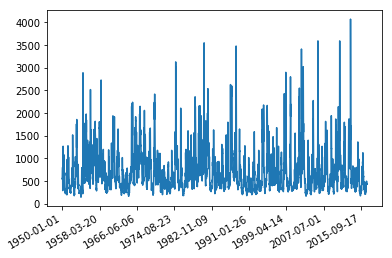

In [7]:
plot_streamflow(df)

- read input data (NetCDF4)

In [8]:
def read_data(filename, folder, varname):
    import netCDF4
    dat = netCDF4.Dataset(folder+ filename)
    print(dat,filename, dat.variables.keys())
    arr = np.array(dat.variables[varname])
    mask = arr < -100
    arr[ mask ] = 0.0
    return arr, mask[0]

def plot_frame(temp:np.array, prec:np.array, mask:np.array, df:pd.DataFrame, frame:int, limits:tuple=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    im_t = np.ma.masked_array(temp[frame], mask=mask)
    im_p = np.ma.masked_array(prec[frame], mask=mask)
    
    ax[0].set_title('Temperature')
    if limits is None:
        cb1 = ax[0].imshow(im_t)
    else:
        cb1 = ax[0].imshow(im_t, vmin=limits[0], vmax=limits[1])
    fig.colorbar(cb1, ax=ax[0], orientation='horizontal')

    ax[1].set_title('Precipitation')
    if limits is None:
        cb2 = ax[1].imshow(im_p)
    else:
        cb2 = ax[1].imshow(im_p, vmin=limits[2], vmax=limits[3])
    fig.colorbar(cb2, ax=ax[1], orientation='horizontal')
    
    for a in ax: a.axis('off')
        
    plt.show()


In [9]:
elev, mask = read_data(data_elev, data_folder, varname='dem_orig')
temp, mask = read_data(data_temp, data_folder, varname='z (unknown)')
prec, mask = read_data(data_prec, data_folder, varname='z (unknown)')


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.4
    created_by: R, packages ncdf4 and raster (version 2.9-23)
    date: 2019-09-08 22:28:57
    dimensions(sizes): longitude(66), latitude(53)
    variables(dimensions): int32 crs(), float64 longitude(longitude), float64 latitude(latitude), float32 dem_orig(latitude,longitude)
    groups:  dem/01_dem.nc odict_keys(['crs', 'longitude', 'latitude', 'dem_orig'])
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.4
    created_by: R, packages ncdf4 and raster (version 2.9-23)
    date: 2019-09-02 19:45:34
    dimensions(sizes): longitude(66), latitude(53), z(24472)
    variables(dimensions): int32 crs(), float64 longitude(longitude), float64 latitude(latitude), float64 z(z), float32 z (unknown)(z,latitude,longitude)
    groups:  01_temp.nc odict_keys(['crs', 'longitude', 'latitude', 'z', 'z (unknown)'])


In [10]:
print(mask.shape)

(53, 66)


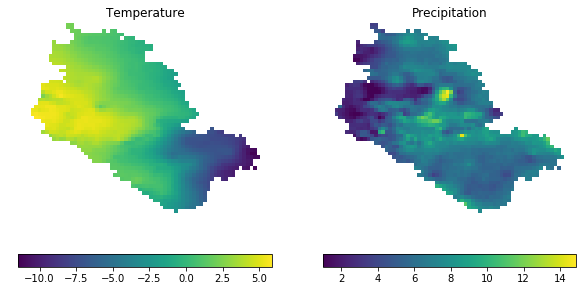

In [11]:
plot_frame(temp, prec, mask, df, frame=11)

# Data preparation

- standardize output data (`y`)

In [12]:
def standardize(data:np.array, return_moments=False):
    mean = np.mean(data)
    std = np.std(data)
    if return_moments:
        return (data-mean)/std, mean, std
    else:
        return (data-mean)/std

Y_MEAN = 704.088
Y_STD  = 439.004
Shape of y =  (24472,)


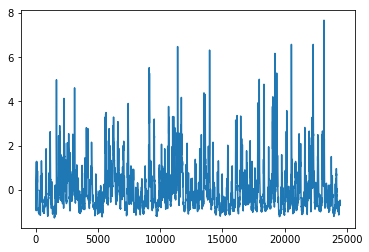

In [13]:
y, Y_MEAN, Y_STD = standardize(df['Q'].values, return_moments=True)
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y = ', y.shape)

# plot data
plt.plot(y)

- standardize and combine input image (`x`)

In [14]:
x_t = standardize(temp) #np.ma.masked_array(temp, mask=mask))
x_p = standardize(prec) #np.ma.masked_array(prec, mask=mask))
x = np.stack([x_t, x_p], axis=-1)
print('Shape of x = ', x.shape)

# plot sample frame
#plot_frame(x_t, x_p, mask, df, frame=11)

Shape of x =  (24472, 53, 66, 2)


- split train and test set
   - here: we don't use `train_test_split` anymore because we are dealing with sequences.
   - we simply take the first part as training data, and the last part as test data

# WARNING: ONLY USING 20% OF DATA

In [15]:
#x = x[:len(x)//5]
#y = y[:len(y)//5]

In [16]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)
train_size = int(0.80 * len(x))
x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

In [17]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_test  = ', x_test.shape)
print('Shape of y_test  = ', y_test.shape)


Shape of x_train =  (19577, 53, 66, 2)
Shape of y_train =  (19577,)
Shape of x_test  =  (4895, 53, 66, 2)
Shape of y_test  =  (4895,)


## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [18]:
# length of image sequence
n_frames = 30
# number of GPUs
n_gpus = 1#4
# adjust this to available GPU memory (VRAM)
batch_size = 92*n_gpus

# use day of year ?
day_of_year = False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = False



In [19]:
from deephydro.generator import ImageSequenceGenerator
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)
generator_test  = ImageSequenceGenerator(data=x_test, labels=y_test, batch_size=batch_size, n_frames=n_frames)

In [20]:
batch = generator_train.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')


Shape of batch_x = (92, 30, 53, 66, 2)
Shape of batch_y = (92,)


In [21]:
#batch[0][0][1]

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [22]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
model = networks.nowcasting_model(input_shape, dayofyear=day_of_year)
#model = networks.get_conv_lstm_model(input_shape)
model.summary()





256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 30, 53, 66, 2)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 26, 32, 16)    10432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 26, 32, 16)    64        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 12, 15, 32)    55424     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 12, 15, 32)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 30, 5, 7, 64)      221440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 5, 7, 64)      256       
__

- compile model: loss, optimizer and metrics

In [23]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc

def build_model(model, 
                loss=logcosh,
                metrics=ccc,
                optimizer=optimizers.Adam(lr=1e-3), 
                n_gpus:int=1):
    if n_gpus > 1:
        from keras.utils import multi_gpu_model
        parallel_model = multi_gpu_model(model, gpus=n_gpus)
        parallel_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return parallel_model
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model


# Training

n_epochs = 2

from deephydro.utils import checkpointer, early_stopping, reduce_learning_rate
callbacks = [checkpointer('./output/model_1ep.h5'), early_stopping(), reduce_learning_rate()]

%%time
if n_gpus > 1:
    parallel_model = build_model(model, loss=logcosh, n_gpus=n_gpus)
    parallel_model.summary()
    history = parallel_model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=3, # if too large, you'll get CPU memory issues (job gets killed)
                              #max_queue_size=10
                              )
else:
    model = build_model(model, loss=logcosh, n_gpus=n_gpus)
    model.summary()
    history = model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=12,
                              #max_queue_size=10
                              )

from deephydro.visualization import plot_history
plot_history(history)

In [27]:
# model.load_weights('./output/model.h5')
model=keras.models.load_model('../output/model.h5' #_wdb_doy_nobatchnorm_dropout.h5'
                              ,custom_objects={"ccc":ccc})

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 30, 53, 66, 2 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 30, 53, 66, 2 0           images[0][0]                     
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 30, 53, 66, 2 0           images[0][0]                     
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 30, 53, 66, 2 0           images[0][0]                     
__________________________________________________________________________________________________
lambda_8 (

# Predict

In [29]:
from deephydro.utils import predict
batch = generator_test.__getitem__(0)
im = batch[0][0]
gt = batch[1][0] * Y_STD + Y_MEAN
y_pred = predict(model, image=im, y_mean=Y_MEAN, y_std=Y_STD)
print(f'Predicted: {y_pred:.2f}, True: {gt:.2f}, Error: {abs(y_pred-gt):.2f}')

Predicted: 470.14, True: 275.08, Error: 195.05


In [30]:
from deephydro.utils import predict_batch
x, y = predict_batch(model, generator=generator_test, n_samples=5#000
                     , y_mean=Y_MEAN, y_std=Y_STD)

0 / 5


(5,)
(5,)
(5,)
(5,)


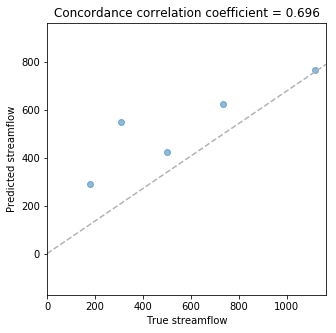

In [31]:
from deephydro.visualization import plot_correlation
plot_correlation(x, y)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

!pip install shap
!pip install tqdm --upgrade

In [32]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][1]
batch[0].shape

(92, 30, 53, 66, 2)

In [33]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, 
                    image=im)
print(shap.shape)

(30, 53, 66, 2)


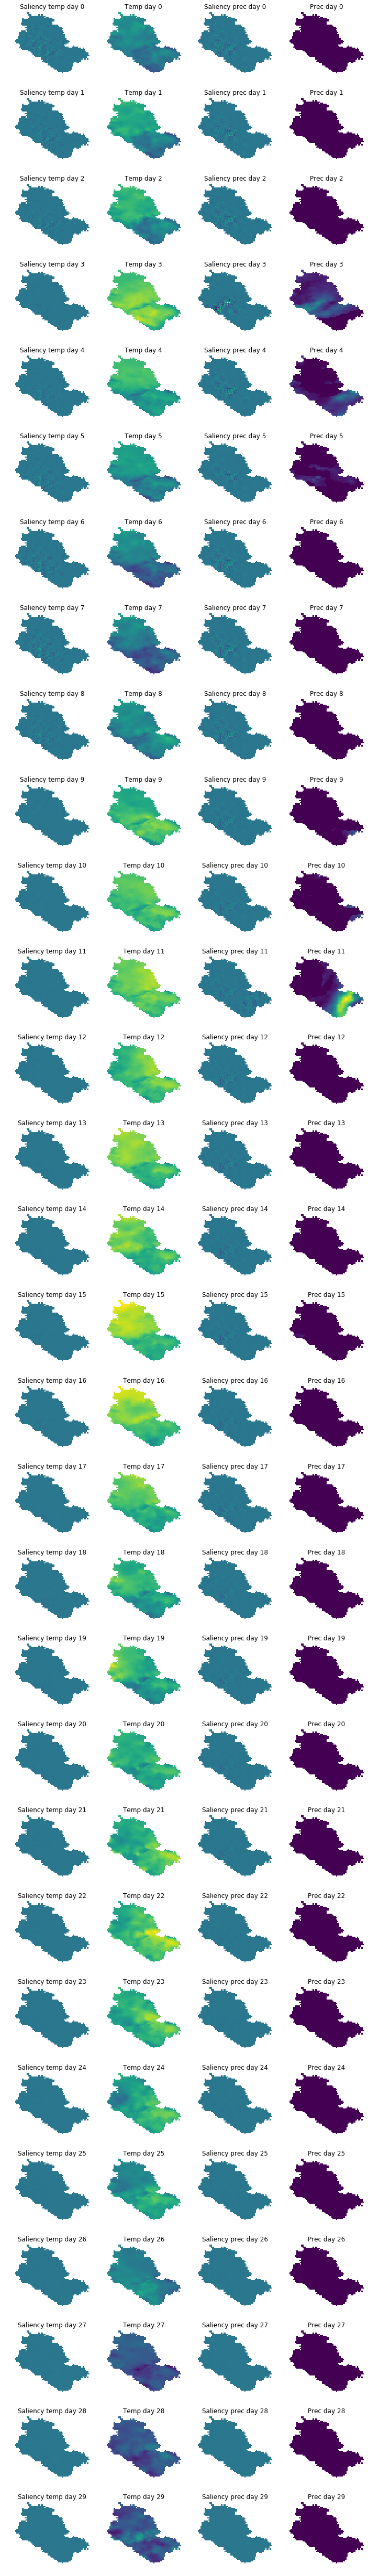

In [34]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)

In [35]:
im.shape

(30, 53, 66, 2)

In [36]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, 
                    image=im)
print(shap.shape)

(30, 53, 66, 2)


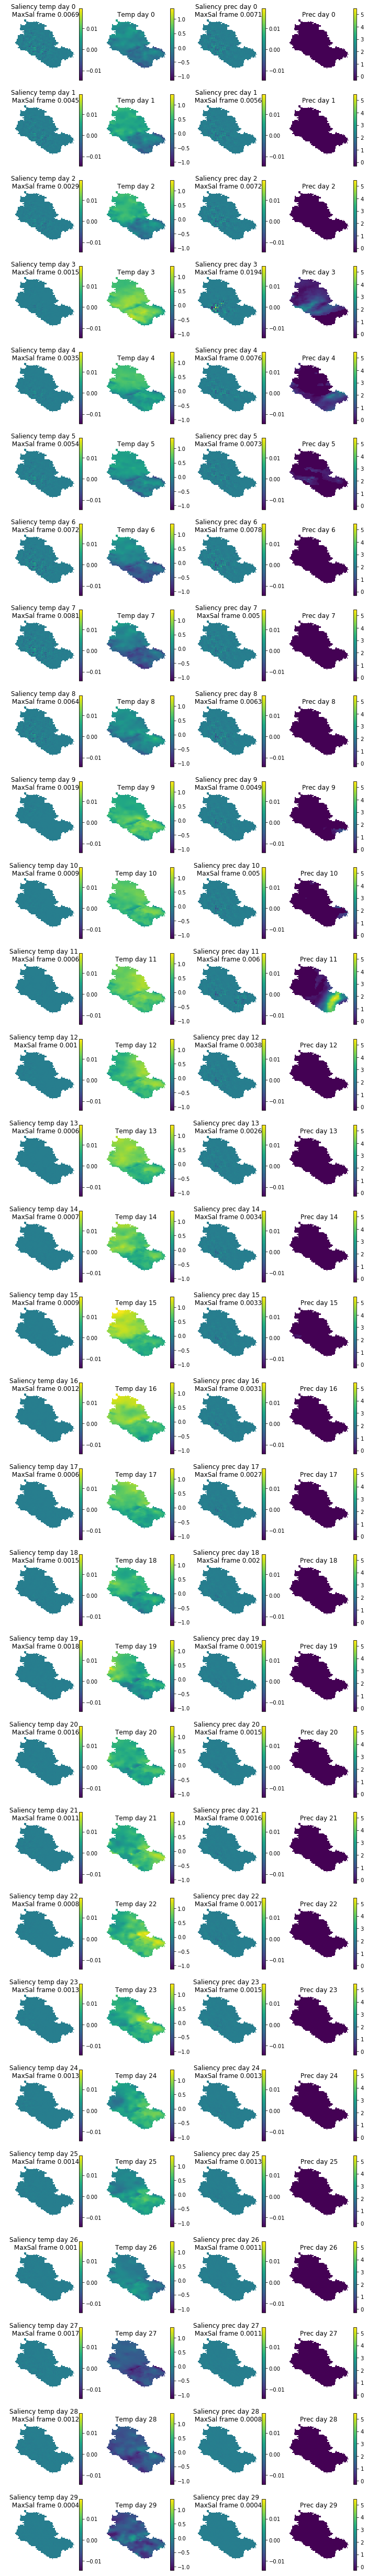

In [37]:
def max_mean_sum(arr):
    return np.max(arr), np.mean(arr), np.sum(arr)
def plot_saliency_return_stats(image, shap_values, mask):
    """ Return statistics of the saliencies and the data for each frame.
    Stats are returned as a pandas DataFrame. 
    Stats can be useful to find correlations between 
    e.g. maximal saliency across temperature image and average temperature for day X"""
    from tqdm import tqdm_notebook as tqdm 

    n_frames = len(image)
    fig, ax = plt.subplots(n_frames, 4, figsize=(2*6, n_frames*3)) 
    stats = np.zeros((n_frames,2*6))
    vmin_sal = np.min( shap_values )
    vmax_sal = np.max( shap_values )
    vmin_t = np.min( image[..., 0] )
    vmax_t = np.max( image[..., 0] )
    vmin_p = np.min( image[..., 1] )
    vmax_p = np.max( image[..., 1] )
    for frame, (im, sal)  in tqdm(enumerate(zip(image, shap_values)), total=len(image)):

        
        vmin = np.min( sal )
        vmax = np.max( sal )
        im_t = np.ma.masked_array(sal[..., 0], mask=mask)
        #t_sal_max,t_sal_mean,t_sal_sum
        stats[frame,:3]= max_mean_sum(im_t)
        #np.around(np.max(im_t),decimals=4)
        ax[frame,0].set_title(f'Saliency temp day {frame} \n MaxSal frame {np.around(np.max(im_t),decimals=4)}')
        ax0_show=ax[frame,0].imshow(im_t, vmin=vmin_sal, vmax=vmax_sal)
        ax[frame,0].axis('off')
        fig.colorbar(ax0_show,ax=ax[frame,0])

        ax[frame,1].set_title(f'Temp day {frame}')
        vmin = np.min( im )
        vmax = np.max( im )
        im_t = np.ma.masked_array(im[..., 0], mask=mask)
        ax1_show = ax[frame,1].imshow(im_t, vmin=vmin_t, vmax=vmax_t)
        ax[frame,1].axis('off')
        fig.colorbar(ax1_show,ax=ax[frame,1])
        stats[frame,3:6]= max_mean_sum(im_t)

    
        vmin = np.min( sal )
        vmax = np.max( sal )
        im_t = np.ma.masked_array(sal[..., 1], mask=mask)
        im_t_sal1_max=np.around(np.max(im_t),decimals=4)
        ax[frame,2].set_title(f'Saliency prec day {frame} \n MaxSal frame {im_t_sal1_max}')
        ax2_show=ax[frame,2].imshow(im_t, vmin=vmin_sal, vmax=vmax_sal)
        ax[frame,2].axis('off')
        fig.colorbar(ax2_show,ax=ax[frame,2])
        stats[frame,6:9]= max_mean_sum(im_t)

        ax[frame,3].set_title(f'Prec day {frame}')
        vmin = np.min( im )
        vmax = np.max( im )
        im_t = np.ma.masked_array(im[..., 1], mask=mask)
        ax3_show=ax[frame,3].imshow(im_t, vmin=vmin_p, vmax=vmax_p)
        ax[frame,3].axis('off')
        fig.colorbar(ax3_show,ax=ax[frame,3])
        stats[frame,9:]= max_mean_sum(im_t)
    
    plt.show()
    
    return pd.DataFrame(stats,columns=['max temp sal','mean temp sal','sum temp sal','max temp','mean temp','sum temp',
                             'max precip sal','mean precip sal','sum precip sal','max precip','mean precip','sum precip'
                            ])
#stats0=pd.DataFrame()
stats0 = plot_saliency_return_stats(image=im, shap_values=shap, mask=mask)

In [ ]:
def plot_saliency_1frame_color(image, shap_values, mask):
    """ Return statistics of the saliencies and the data for each frame.
    Stats are returned as a pandas DataFrame. 
    Stats can be useful to find correlations between 
    e.g. maximal saliency across temperature image and average temperature for day X"""
    from tqdm import tqdm_notebook as tqdm 

    n_frames = len(image)
    fig, ax = plt.subplots(n_frames, 4, figsize=(2*6, n_frames*3)) 
    stats = np.zeros((n_frames,2*6))
    vmin_sal = np.min( shap_values )
    vmax_sal = np.max( shap_values )
    vmin_t = np.min( image[..., 0] )
    vmax_t = np.max( image[..., 0] )
    vmin_p = np.min( image[..., 1] )
    vmax_p = np.max( image[..., 1] )
    for frame, (im, sal)  in tqdm(enumerate(zip(image, shap_values)), total=len(image)):

        
        vmin = np.min( sal[..., 0] )
        vmax = np.max( sal[..., 0] )
        im_t = np.ma.masked_array(sal[..., 0], mask=mask)
        #t_sal_max,t_sal_mean,t_sal_sum
        stats[frame,:3]= max_mean_sum(im_t)
        #np.around(np.max(im_t),decimals=4)
        ax[frame,0].set_title(f'Saliency temp day {frame} \n MaxSal frame {np.around(np.max(im_t),decimals=4)}')
        ax0_show=ax[frame,0].imshow(im_t, vmin=vmin#_sal
                                    , vmax=vmax) #_sal)
        ax[frame,0].axis('off')
        fig.colorbar(ax0_show,ax=ax[frame,0])

        ax[frame,1].set_title(f'Temp day {frame}')
        vmin = np.min( im )
        vmax = np.max( im )
        im_t = np.ma.masked_array(im[..., 0], mask=mask)
        ax1_show = ax[frame,1].imshow(im_t, vmin=vmin_t, vmax=vmax_t)
        ax[frame,1].axis('off')
        fig.colorbar(ax1_show,ax=ax[frame,1])
        stats[frame,3:6]= max_mean_sum(im_t)

    
        vmin = np.min( sal[..., 1] )
        vmax = np.max( sal[..., 1] )
        im_t = np.ma.masked_array(sal[..., 1], mask=mask)
        im_t_sal1_max=np.around(np.max(im_t),decimals=4)
        ax[frame,2].set_title(f'Saliency prec day {frame} \n MaxSal frame {im_t_sal1_max}')
        ax2_show=ax[frame,2].imshow(im_t, vmin=vmin#_sal
                                    , vmax=vmax) #_sal)
        ax[frame,2].axis('off')
        fig.colorbar(ax2_show,ax=ax[frame,2])
        stats[frame,6:9]= max_mean_sum(im_t)

        ax[frame,3].set_title(f'Prec day {frame}')
        vmin = np.min( im )
        vmax = np.max( im )
        im_t = np.ma.masked_array(im[..., 1], mask=mask)
        ax3_show=ax[frame,3].imshow(im_t, vmin=vmin_p, vmax=vmax_p)
        ax[frame,3].axis('off')
        fig.colorbar(ax3_show,ax=ax[frame,3])
        stats[frame,9:]= max_mean_sum(im_t)
    
    plt.show()
    
    return pd.DataFrame(stats,columns=['max temp sal','mean temp sal','sum temp sal','max temp','mean temp','sum temp',
                             'max precip sal','mean precip sal','sum precip sal','max precip','mean precip','sum precip'
                            ])
#stats0=pd.DataFrame()
stats0 = plot_saliency_1frame_color(image=im, shap_values=shap, mask=mask)

In [38]:
stats0 #which time points are important
# also do per region (in the image)

max temp sal  mean temp sal  sum temp sal  max temp  mean temp  \
0       0.006853   5.247810e-05      0.088006  0.370753  -0.037514   
1       0.004534   1.594721e-05      0.026743  0.698727   0.178474   
2       0.002921   1.030724e-05      0.017285  0.710440   0.266139   
3       0.001540  -8.410095e-06     -0.014104  1.212651   0.748900   
4       0.003466   1.277178e-05      0.021418  0.732403   0.405636   
5       0.005449   1.759429e-05      0.029506  0.426391   0.104135   
6       0.007186   1.925256e-05      0.032287  0.356111  -0.143455   
7       0.008094   1.618788e-05      0.027147  0.318043  -0.200971   
8       0.006422   1.002886e-05      0.016818  0.553774   0.045366   
9       0.001913   2.635841e-06      0.004420  0.993025   0.536949   
10      0.000908  -2.051087e-07     -0.000344  0.927137   0.638568   
11      0.000641  -8.367347e-08     -0.000140  1.139442   0.762669   
12      0.000992  -2.587806e-06     -0.004340  1.067698   0.643084   
13      0.000612  -1.836249e-06     -0.003079  1.096981   0.742754   
14      0.000748  -6.710414e-06     -0.011253  1.089661   0.671899   
15      0.000896  -4.349231e-06     -0.007294  1.363460   0.814329   
16      0.001163  -3.582120e-06     -0.006007  1.297573   0.788022   
17      0.000592  -5.644268e-06     -0.009465  1.075019   0.588865   
18      0.001458  -1.245683e-05     -0.020890  1.019380   0.389330   
19      0.001751  -1.183628e-05     -0.019849  1.376638   0.418480   
20      0.001577  -9.237867e-06     -0.015492  0.902247   0.423342   
21      0.001131  -7.437512e-06     -0.012473  1.127729   0.495645   
22      0.000775  -5.372537e-06     -0.009010  1.329784   0.631107   
23      0.001292  -3.839981e-06     -0.006440  1.114551   0.499277   
24      0.001349  -4.181196e-06     -0.007012  0.862714   0.356560   
25      0.001385  -2.324126e-07     -0.000390  0.789506   0.193966   
26      0.000985   2.491911e-06      0.004179  0.363432  -0.025661   
27      0.001677   2.392142e-07      0.000401 -0.216380  -0.468651   
28      0.001160  -5.015366e-06     -0.008411  0.026673  -0.467590   
29      0.000429  -4.170412e-06     -0.006994  0.388323  -0.456666   

       sum temp  max precip sal  mean precip sal  sum precip sal  max precip  \
0    -62.911331        0.007118     5.394858e-06        0.009047   -0.291149   
1    299.301025        0.005554    -1.005914e-06       -0.001687   -0.291149   
2    446.315430        0.007168     6.367891e-06        0.010679   -0.291149   
3   1255.905029        0.019421     2.826460e-06        0.004740    2.539758   
4    680.251831        0.007608     5.757695e-06        0.009656    2.898101   
5    174.634232        0.007320     4.063253e-06        0.006814    1.249724   
6   -240.573792        0.007819     6.034885e-07        0.001012   -0.291149   
7   -337.028931        0.005004    -9.462045e-07       -0.001587   -0.291149   
8     76.077980        0.006255    -1.736062e-06       -0.002911   -0.291149   
9    900.463074        0.004917    -1.176418e-05       -0.019729    1.464730   
10  1070.879272        0.005021    -1.624387e-05       -0.027241    1.428896   
11  1278.996582        0.006031    -4.693734e-05       -0.078714    5.478168   
12  1078.452026        0.003820    -1.870368e-05       -0.031366   -0.291149   
13  1245.598877        0.002557    -1.699294e-05       -0.028497   -0.291149   
14  1126.775391        0.003389    -2.223792e-05       -0.037293   -0.291149   
15  1365.630005        0.003311    -2.134028e-05       -0.035788    0.246365   
16  1321.513062        0.003078    -2.400191e-05       -0.040251   -0.291149   
17   987.526978        0.002677    -2.049437e-05       -0.034369   -0.291149   
18   652.906982        0.002000    -1.881107e-05       -0.031546   -0.291149   
19   701.791260        0.001943    -1.878364e-05       -0.031500   -0.291149   
20   709.945190        0.001467    -1.661371e-05       -0.027861   -0.291149   
21   831.196045        0.001573    -1.686116e-05       -0.028276   -0.291

#  Grad-CAM

In [39]:
li=0
for l in model.layers:
        print(l.name)

images
lambda_5
lambda_6
lambda_7
lambda_8
model_1
dense_2


In [40]:
model.layers[-2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 30, 53, 66, 2)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 26, 32, 16)    10432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 26, 32, 16)    64        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 12, 15, 32)    55424     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 12, 15, 32)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 30, 5, 7, 64)      221440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 5, 7, 64)      256       
__________

In [41]:
realmodel=model.layers[-2]
realmodel.layers[-4].name

'conv_lst_m2d_4'

In [42]:
realmodel.get_input_at(0)

<tf.Tensor 'images_4:0' shape=(?, 30, 53, 66, 2) dtype=float32>

In [43]:
model.layers[-3]#.lambda_8

In [50]:
Debug=True#False
from keras import backend as K
import cv2
def grad_mask_1px_scapes(input_model, image,predictions, 
                         #prop_from_layer,
                         prop_to_layer='conv_lst_m2d_2', 
                         normalize=True,abs_w=False,posit_w=False): #aka grad_cam3
    """GradCAM that works for one pixel in the class' mask """
    print(image.shape)
    preprocessed_input = np.expand_dims(image, 0)#load_image(img_path)
    #img = np.expand_dims(img, 0)
    #predictions = input_model.predict(preprocessed_input)
    #print(predictions)
    predicted_class = predictions
    print("predicted_class: ", predicted_class)
    #if cls == -1:
     #   cls = predicted_class
    #print("Classes: 0 = background, 1 = rectangle, 2 = circle")
    #print("Grad-CAM for class:", cls)
    prop_from_layer = input_model.layers[-1].name #last dense
    #prop_to_layer = input_model.layers[3].name #first convlstm | last = -4
    print("prop_to_layer ",prop_to_layer)
    y_c = input_model.get_layer(prop_from_layer).output#[...,i,j,cls]
    conv_output = input_model.get_layer(prop_to_layer).output
    grads = K.gradients(y_c, conv_output)[0]
    """
    Arguments:
    loss: Scalar tensor to minimize.
    variables: List of variables.
    Returns: A gradients tensor."""
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.get_input_at(0)], [conv_output, grads])
    """The part of code snippet is as follows -

    final_conv_layer = get_output_layer(model, "conv5_3")
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
In this code, there is a model from which "conv5_3" layer is extracted (line 1). 
iN the function K.function(), first argument is input to this model and second is set of 2 
outputs - one for convolution and second for softmax output at the last layer.

As per the Keras/Tensorflow manual, this function runs the computation graph that we have created 
in the code, taking input from the first parameter and extracting the number of outputs as per the
 layers mentioned in the second parameter. Thus, conv_outputs are output of final_conv_layer and 
 predictions are output of model.layers[-1] i.e. last layer of the model.

shareimprove this answer"""
    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    print("output, grads_val shapes: ",output.shape, grads_val.shape)
    #print("output[0, :], grads_val[0, :, :, :] ; ",output, grads_val)
    weights = np.mean(grads_val, axis=(0, 1,2))#,3))
    
    if abs_w:
        weights = abs(weights)
    if posit_w:
        weights=np.maximum(weights,0)
        
    cam = np.dot(output, weights) #*abs(grads_val) or max(grads_val,0)
    img_dim = image.shape[1:3]
    if Debug:
        print("image shape: ", image.shape)
        print("cam shape: ", cam.shape)
        print("img_dim: ",img_dim)
        #print("input_model.output ",input_model.output)#str(K.eval(input_model.output))) #str(y_true.eval())
        #print("y_c: ", y_c)
        #print("conv_output: ",conv_output)
        #print("K.gradients(y_c, conv_output) ", K.gradients(y_c, conv_output))
        #print("K.gradients(y_c, conv_output)[0] aka grads: ", grads)
        #print("gradient_function: ",gradient_function)
        print("output.shape, grads_val.shape: ",output.shape, grads_val.shape)
        #print("output, grads_val: ",output, grads_val)
        print("weights.shape : ",weights.shape)
    # Process CAM
    print("cam T shape: ", cam.T.shape)
    unresizedcam=cam
    cam = cv2.resize(cam.T, img_dim)#[::-1])#, cv2.INTER_LINEAR) #cv2.resize(image,(width,height))
    print("resized cam shape: ", cam.shape)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0 and normalize: 
        cam = cam / cam_max
    return cam,predicted_class, unresizedcam


In [ ]:
gradcam.T[0].shape

In [ ]:
plt.imshow(gradcam.T[0])

In [ ]:
mask_gradcam = np.ma.masked_array(gradcam.T[0], mask=mask)

In [ ]:
mask_gradcam.shape

In [ ]:
mask.shape

In [ ]:
plt.imshow(mask_gradcam)
plt.colorbar()

(30, 53, 66, 2)
predicted_class:  470.1353840662807
prop_to_layer  conv_lst_m2d_1
output, grads_val shapes:  (30, 26, 32, 16) (30, 26, 32, 16)
image shape:  (30, 53, 66, 2)
cam shape:  (30, 26, 32)
img_dim:  (53, 66)
output.shape, grads_val.shape:  (30, 26, 32, 16) (30, 26, 32, 16)
weights.shape :  (16,)
cam T shape:  (32, 26, 30)
resized cam shape:  (66, 53, 30)


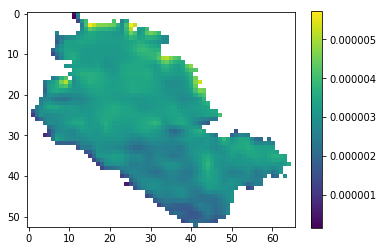

In [51]:
gradcam_1lstm = grad_mask_1px_scapes(realmodel, im,y_pred,normalize=False,prop_to_layer='conv_lst_m2d_1' )
frame_n = 0
mask_gradcam = np.ma.masked_array(gradcam_1lstm[0].T[frame_n], mask=mask)
plt.imshow(mask_gradcam)
plt.colorbar()

(30, 53, 66, 2)
predicted_class:  470.1353840662807
prop_to_layer  conv_lst_m2d_2
output, grads_val shapes:  (30, 12, 15, 32) (30, 12, 15, 32)
image shape:  (30, 53, 66, 2)
cam shape:  (30, 12, 15)
img_dim:  (53, 66)
output.shape, grads_val.shape:  (30, 12, 15, 32) (30, 12, 15, 32)
weights.shape :  (32,)
cam T shape:  (15, 12, 30)
resized cam shape:  (66, 53, 30)


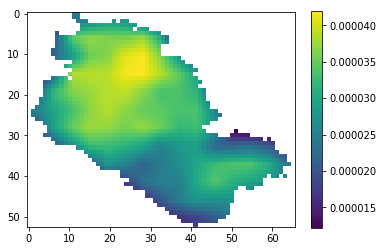

In [52]:
# try to take 2nd convlstm in gradcam
gradcam_2lstm = grad_mask_1px_scapes(realmodel, im,y_pred,normalize=False)
frame_n = 0
mask_gradcam = np.ma.masked_array(gradcam_2lstm[0].T[frame_n], mask=mask)
plt.imshow(mask_gradcam)
plt.colorbar()

(30, 53, 66, 2)
predicted_class:  470.1353840662807
prop_to_layer  conv_lst_m2d_3
output, grads_val shapes:  (30, 5, 7, 64) (30, 5, 7, 64)
image shape:  (30, 53, 66, 2)
cam shape:  (30, 5, 7)
img_dim:  (53, 66)
output.shape, grads_val.shape:  (30, 5, 7, 64) (30, 5, 7, 64)
weights.shape :  (64,)
cam T shape:  (7, 5, 30)
resized cam shape:  (66, 53, 30)


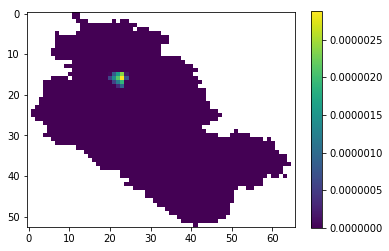

In [53]:
# try to take 2nd convlstm in gradcam
# is gradcam to last convlstm just (2,3) or (30,2,3)?
gradcam_3lstm = grad_mask_1px_scapes(realmodel, im,y_pred,normalize=False,prop_to_layer='conv_lst_m2d_3' )
frame_n = 0
mask_gradcam = np.ma.masked_array(gradcam_3lstm[0].T[frame_n], mask=mask)
plt.imshow(mask_gradcam)
plt.colorbar()

In [54]:
# try to take 2nd convlstm in gradcam
# is gradcam to last convlstm just (2,3) or (30,2,3)?
gradcam_4lstm = grad_mask_1px_scapes(realmodel, im,y_pred,normalize=False,prop_to_layer='conv_lst_m2d_4' )
""" visualization doesn't make sence
frame_n = 0
mask_gradcam = np.ma.masked_array(gradcam_4lstm.T[frame_n], mask=mask)
plt.imshow(mask_gradcam)
plt.colorbar()"""

(30, 53, 66, 2)
predicted_class:  470.1353840662807
prop_to_layer  conv_lst_m2d_4
output, grads_val shapes:  (2, 3, 128) (2, 3, 128)
image shape:  (30, 53, 66, 2)
cam shape:  (2, 3, 128)
img_dim:  (53, 66)
output.shape, grads_val.shape:  (2, 3, 128) (2, 3, 128)
weights.shape :  ()
cam T shape:  (128, 3, 2)
resized cam shape:  (66, 53, 2)


" visualization doesn't make sence\nframe_n = 0\nmask_gradcam = np.ma.masked_array(gradcam_4lstm.T[frame_n], mask=mask)\nplt.imshow(mask_gradcam)\nplt.colorbar()"

(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)
(53, 66)



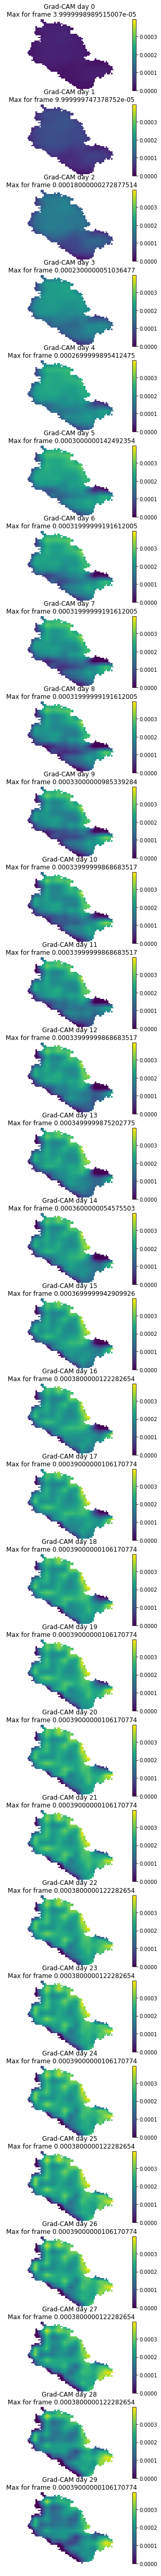

In [70]:
# plot gradcams for all frames, plot avg, max
def plot_gradcams_all_frames(gradcam, mask):
    """for frame_n in range(gradcam[0].shape[0]):
    mask_gradcam = np.ma.masked_array(gradcam.T[frame_n], mask=mask)
    plt.imshow(mask_gradcam)
    plt.colorbar()"""
    
    from tqdm import tqdm_notebook as tqdm 

    n_frames = gradcam[0].T.shape[0]
    fig, ax = plt.subplots(n_frames, #4, 
                           figsize=(2*6, n_frames*3)) 
    stats = np.zeros((n_frames,2*6))
    vmin_sal = np.min( gradcam[0] )
    vmax_sal = np.max( gradcam[0] )
    """vmin_t = np.min( image[..., 0] )
    vmax_t = np.max( image[..., 0] )
    vmin_p = np.min( image[..., 1] )
    vmax_p = np.max( image[..., 1] )"""
    for frame, cam  in tqdm(enumerate(gradcam[0].T#zip(image, shap_values)
                                         ), total=n_frames):

        
        #vmin = np.min( sal[..., 0] )
        #vmax = np.max( sal[..., 0] )
        im_t = np.ma.masked_array(cam#.T
                                  #[frame_n]
                                  , mask=mask)
        print(im_t.shape)
        #t_sal_max,t_sal_mean,t_sal_sum
        #stats[frame
             #,:3
             #]= max_mean_sum(im_t)
        #np.around(np.max(im_t),decimals=4)
        ax[frame
           #,0
          ].set_title(f'Grad-CAM day {frame} \n Max for frame {np.around(np.max(im_t),decimals=5)}')
        ax0_show=ax[frame
                    #,0
                   ].imshow(im_t, vmin=vmin_sal
                                    , vmax=vmax_sal)
        ax[frame
           #,0
          ].axis('off')
        fig.colorbar(ax0_show,ax=ax[frame])#,0])
    plt.show()
    """
        ax[frame,1].set_title(f'Temp day {frame}')
        vmin = np.min( im )
        vmax = np.max( im )
        im_t = np.ma.masked_array(im[..., 0], mask=mask)
        ax1_show = ax[frame,1].imshow(im_t, vmin=vmin_t, vmax=vmax_t)
        ax[frame,1].axis('off')
        fig.colorbar(ax1_show,ax=ax[frame,1])
        stats[frame,3:6]= max_mean_sum(im_t)

    
        vmin = np.min( sal[..., 1] )
        vmax = np.max( sal[..., 1] )
        im_t = np.ma.masked_array(sal[..., 1], mask=mask)
        im_t_sal1_max=np.around(np.max(im_t),decimals=4)
        ax[frame,2].set_title(f'Saliency prec day {frame} \n MaxSal frame {im_t_sal1_max}')
        ax2_show=ax[frame,2].imshow(im_t, vmin=vmin#_sal
                                    , vmax=vmax) #_sal)
        ax[frame,2].axis('off')
        fig.colorbar(ax2_show,ax=ax[frame,2])
        stats[frame,6:9]= max_mean_sum(im_t)

        ax[frame,3].set_title(f'Prec day {frame}')
        vmin = np.min( im )
        vmax = np.max( im )
        im_t = np.ma.masked_array(im[..., 1], mask=mask)
        ax3_show=ax[frame,3].imshow(im_t, vmin=vmin_p, vmax=vmax_p)
        ax[frame,3].axis('off')
        fig.colorbar(ax3_show,ax=ax[frame,3])
        stats[frame,9:]= max_mean_sum(im_t)"""
    
    #plt.show()
plot_gradcams_all_frames(gradcam_2lstm, mask)

(53, 66)


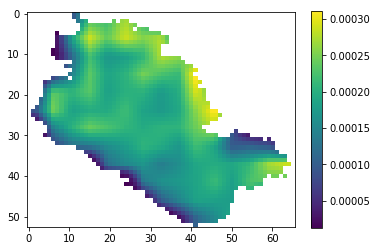

In [74]:
# avg across frames
gradcam_2lstm_avg = np.mean(gradcam_2lstm[0].T, axis=0)
print(gradcam_2lstm_avg.shape)
mask_gradcam = np.ma.masked_array(gradcam_2lstm_avg, mask=mask)
plt.imshow(mask_gradcam)
plt.colorbar()

(53, 66)


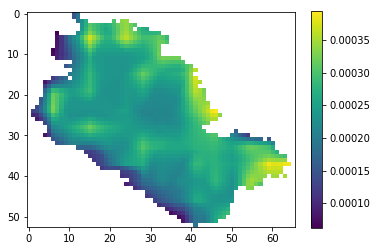

In [75]:
# max across frames
gradcam_2lstm_max = np.max(gradcam_2lstm[0].T, axis=0)
print(gradcam_2lstm_max.shape)
mask_gradcam = np.ma.masked_array(gradcam_2lstm_max, mask=mask)
plt.imshow(mask_gradcam)
plt.colorbar()

In [79]:
gradcam_3lstm[-1].shape

(30, 5, 7)

In [81]:
np.mean(gradcam_3lstm[-1], axis=(1,2))

array([-5.0115032e-05, -4.1432762e-05,  3.5524281e-06,  8.6786540e-06,
        1.2438043e-05,  1.3126159e-05,  6.5679728e-06, -1.1555237e-06,
       -7.0846539e-07,  8.5039019e-06,  1.3362650e-05,  1.8078475e-05,
        2.4168066e-05,  3.5279310e-05,  4.2439864e-05,  4.6550431e-05,
        4.6257075e-05,  4.1472900e-05,  3.0282838e-05,  1.4937115e-05,
       -2.0686941e-06, -1.8410865e-05, -3.1764579e-05, -4.3214572e-05,
       -5.3362233e-05, -6.0881855e-05, -6.3316453e-05, -5.9344879e-05,
       -4.9554830e-05, -3.8240123e-05], dtype=float32)

[<matplotlib.lines.Line2D at 0x19af350dc88>]

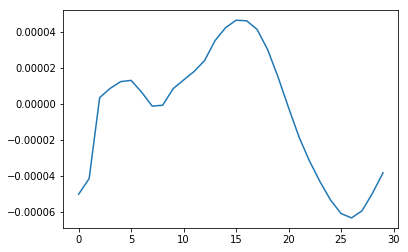

In [82]:
plt.plot(range(30),np.mean(gradcam_3lstm[-1], axis=(1,2)))

[<matplotlib.lines.Line2D at 0x19af356ae48>]

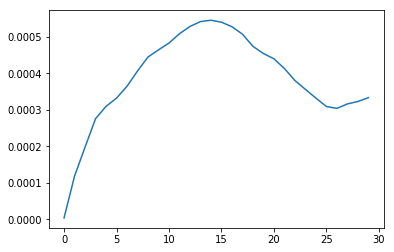

In [83]:
# max importance captured by the prelast convLSTM layer
plt.plot(range(30),np.max(gradcam_3lstm[-1], axis=(1,2)))

In [ ]:
# plot gradcams for all frames, plot avg, max +
# compare frame's importance produced by gradcam vs by shap
# compare spatial (each pixel's) importance produced by gradcam vs by shap